**[게임 데이터 풀잎]**
# 🎮 게임 유저의 LTV 예측

[[NC 테크 블로그]오랫동안 사랑받는 게임이 되도록, 유저의 LTV(유저 생애 가치) 예측하기](https://blog.ncsoft.com/game-data-analytics-20201014/)  
[[Nexon Developers Conference]데브시스터즈 발표](http://ndcreplay.nexon.com/NDC2019/sessions/NDC2019_0026.html#c=NDC2019&k%5B%5D=LT)


### LTV란?

*고객 생애 가치 (Life Time Value)*  
특정 서비스를 이용하는 **고객이 일생에 얼마만큼의 이익을 줄 것인지를 정량적으로 추정한 것**으로 CLV(Customer Lifetime Value)라고도 합니다.

[LTV 이해하기](https://sungmooncho.com/2011/11/21/customer-lifetime-value/)


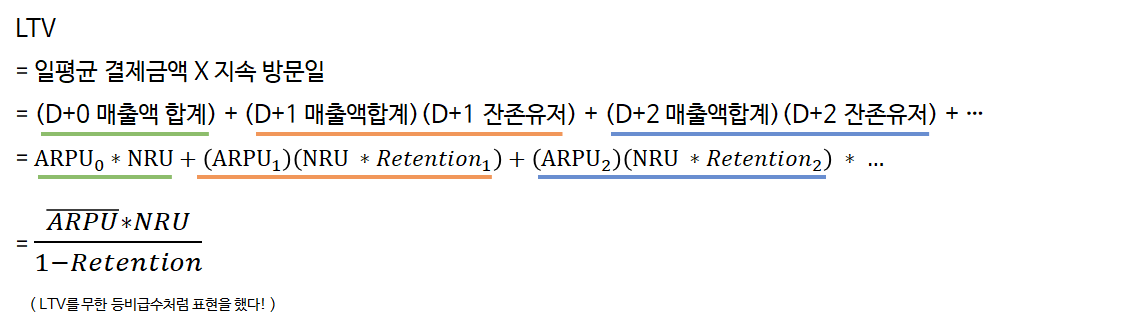

- ARPU: 유저의 일 평균 결제금액
- NRU: 신규 가입 유저
- Retention_i: 가입후 i일이 지난 뒤, 들어온 NRU의 비율
(ex: 100명의 NRU중 3일뒤 50명이 접속했다면 Retention_3은 50%가 된다)

### LTV 추정이 왜 필요할까?

* 장단기적 성과 예측 → 전략 수립

* LTV 에 따른 차별화된 마케팅 (국가, OS 등)

* 향후 출시될 기능과 신제품을 제작 및 제공하는 데 드는 비용 추정

[구글 Developers의 LTV 계산기](https://developer.android.com/distribute/ltv-calculator?hl=ko)

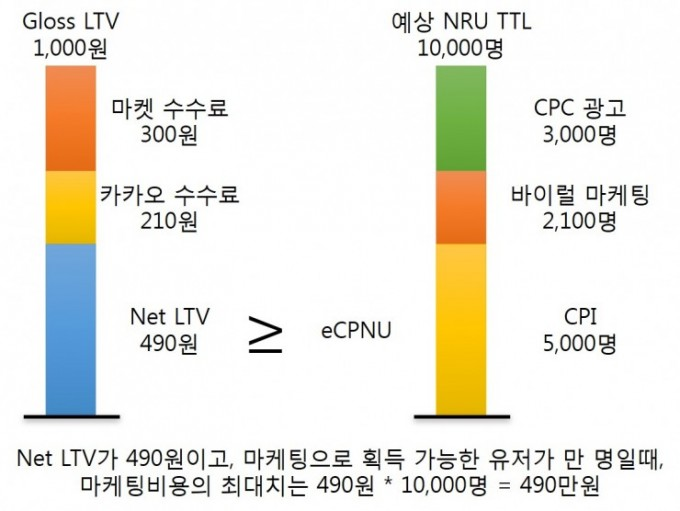

___
## 🔎 전통적인 LTV 추정 방식

### (1) 등비수열을 이용한 추정

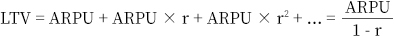

* 문제 1: ARPU가 일정하지 않다

* 문제 2: r이 일정하지 않다

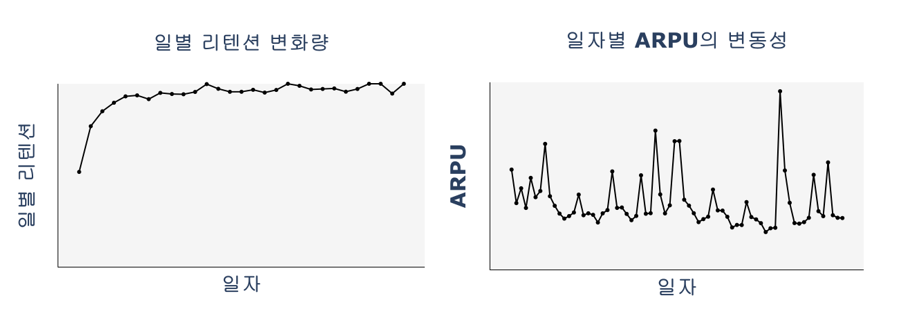

### (2) 예측모델(Random Forest)을 이용한 추정

* 유저의 여러가지 피쳐를 이용하여 LTV 예측하는 방식

* RFM 피쳐: 거래의 최근성(Recency), 빈도(Frequency), 규모(Monatary)

* 문제
  - 모든 게임에 범용적으로 적용할 수 있는 피처를 찾기 어려움
  - 시간이 지남에 따라 모델의 성능 떨어짐(유지보수 비용 高)

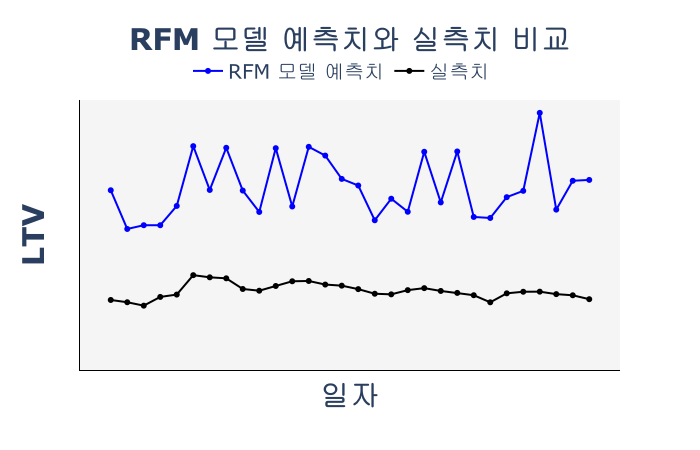

___
## 🔎 단점을 보완한 새로운 LTV 추정 기법

* 일반적인 기법 개발 👉 기본적인 데이터인 ARPU와 리텐션만을 이용

* 적은 데이터로도 추정 가능 + 시간이 지남에 따라 정확해지는 모델 


### (1) 단위 기간 당 ARPU 추정하기

* ARPU는 변동성이 매우 큼(주말, 방학 등 특정 시기, 대규모 프로모션이나 이벤트의 영향)

* 따라서 모델링으로 예측하기 보다는 일자별 **이동 평균**을 구하여 변동성 최소화

[이동평균](https://www.econowide.com/3544)

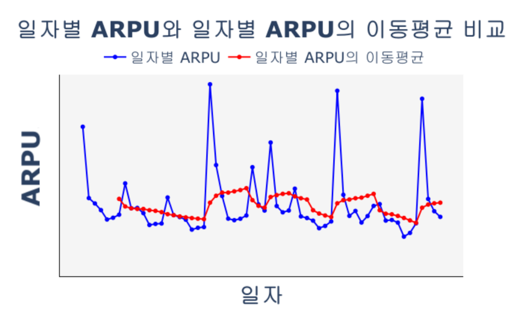

### (2) 리텐션 추정하기

* 이탈률이 아닌 접속률을 이용하여 추정

  * 이탈률: 아예 해당 게임을 더 이상 하지 않는 유저의 비율

  * 접속률: 기준일에 접속한 유저가 n일 후에 접속한 비율 

    1월 1일에 접속한 유저가 100명 → 접속률: 100/100  
    100명 중 1월 2일에 접속한 유저가 50명 → 접속률: 50/100  
    100명 중 1월 3일에 접속한 유저가 55명 → 접속률: 55/100

* 접속률이 전날보다 상승한 경우, 이전 시점까지 접속률 중 최소값으로 대체하도록 전처리

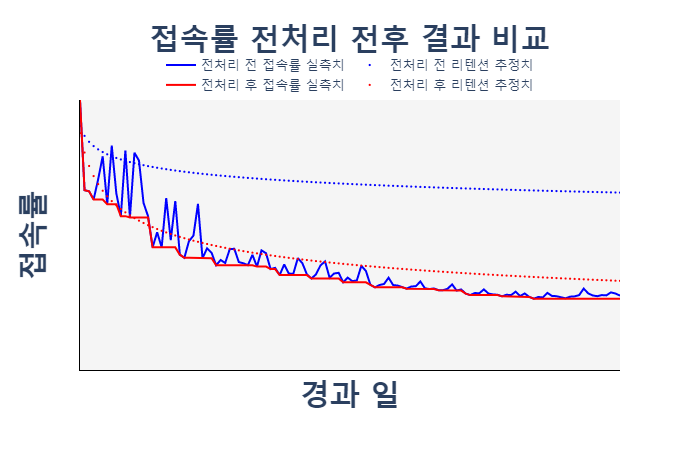





* 리텐션 추정 방법
  - **유리함수 적합**: 리텐션 그래프를 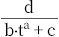형태로 가정하고 a,b,c,d 값 구하기
  - **sBG 모델(shifted-beta-geometric)**: 확률 분포(베타 분포)를 이용해 잔존률 구하기
  - 두 방법의 평균을 이용해 최종 리텐션 추정치 계산

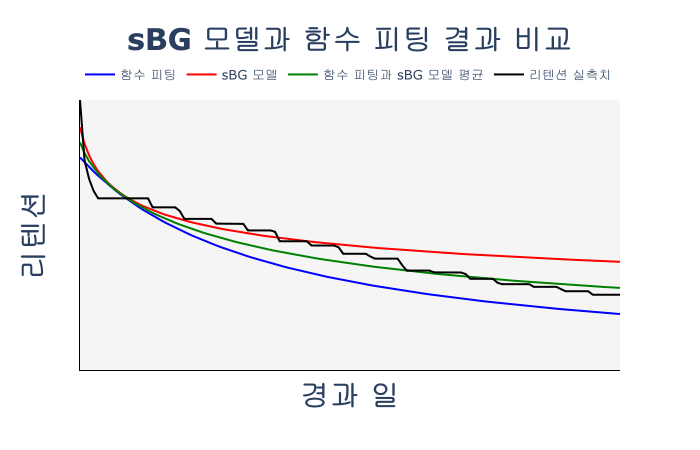

### (3) 최종 LTV 계산

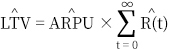

* t가 지나치게 커지면 LTV를 과대추정하게 됨

* 월, 분기, 반기, 년 단위의 기간별 LTV 도출


___

# 🚩 [프로젝트] Retention Curve 추정하기


## 가상의 User Dataset 만들기

[Retention Dataset 생성](https://github.com/Data-Indepedent/pandas_everything/blob/master/pair_programming/Pair_Programming_7a_Creating_Retention_Dataset.ipynb)

[Retention 계산](https://github.com/Data-Indepedent/pandas_everything/blob/master/pair_programming/Pair_Programming_7b_Calculating_Retention.ipynb)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uuid
import datetime
import random

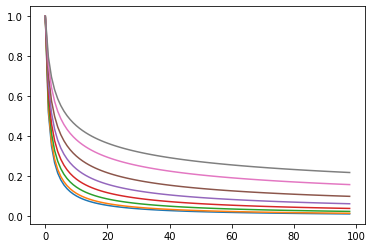

In [ ]:
dfu = pd.DataFrame()
start_day = 1
end_day = 100

for i, cohort in enumerate([.95, .9, .8, .7, .6, .5, .4, .33]):  
    
    start_date = datetime.date(2020, i+1, 1)
    end_date = datetime.date(2020, i+2, 1)

    time_between_dates = end_date - start_date
    days_between_dates = time_between_dates.days

    p = 1 / np.power(range(start_day,end_day), cohort)

    dfc = pd.DataFrame()
    users = []
    user_ids = []
    user_start_date = []
    for user in range(int((((1 - cohort) * 5000) + np.random.randint(50,200)))):
        
        random_number_of_days = random.randrange(days_between_dates)
        random_date = start_date + datetime.timedelta(days=random_number_of_days)
        user_start_date.append(random_date)
        
        user_active = np.random.binomial(1, p)
        users.append(user_active)
        user_ids.append(str(uuid.uuid4()))
    dfc = dfc.append(users)
  
    dfc['cohort'] = i
    dfc['user_id'] = user_ids
    dfc['start_date'] = user_start_date
    dfu = dfu.append(dfc, ignore_index=True)

    plt.plot(p);

In [ ]:
dfu = dfu.melt(id_vars=['user_id', 'start_date', 'cohort'], value_vars=range(start_day-1,end_day-1), value_name='active', var_name='day_since_start')
dfu = dfu[dfu['active']==1]
dfu['start_date'] = pd.to_datetime(dfu['start_date'])
dfu['day'] = dfu['start_date'] + dfu['day_since_start'].apply(lambda x: pd.Timedelta(x, unit='d'))

In [ ]:
dfu.to_csv('/content/drive/MyDrive/fullretentiondata.csv', index=False)

In [ ]:
dfu[['user_id', 'day', 'active']].to_csv('/content/drive/MyDrive/RetentionDataset.csv', index=False)

## Retention 계산하기

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/RetentionDataset.csv', parse_dates=['day'])
print("You have {} rows in your data".format(len(df)))
df.head()

You have 296910 rows in your data


,user_id,day,active
0,bbdb0c05-cf98-48b5-8f8e-4d78827233e8,2020-01-18,1
1,ff4fd503-3279-4dec-b3e5-33be29ef39de,2020-01-01,1
2,589df44a-1e36-4b45-9813-504ebcc4848f,2020-01-01,1
3,27ee0e7e-7165-4ae4-9137-fbc5ba5b605d,2020-01-16,1
4,a95752e1-0760-43a5-908f-eb8395749096,2020-01-22,1


`user_id` 당 가장 첫번째 날짜를 가져온다.  
이 날짜를 기준 날짜로 설정할 것이다.

In [ ]:
# Get the first day a user was active
start_date = df.groupby('user_id')['day'].min()
start_date = start_date.rename("start_day")
start_date.head()

user_id
0006f19e-41d8-4187-bcfc-96090695c906   2020-04-12
000bbc50-26dd-4484-89af-12e0ad4d6892   2020-02-10
00127470-ec13-4ea1-9a20-a6e89806da75   2020-08-18
00151e82-2fa8-486a-ab20-822a15f8796b   2020-04-05
001a0d16-b9ef-46e0-8689-51689ed813ea   2020-06-15
Name: start_day, dtype: datetime64[ns]

첫번째 날짜를 `start_day`로 가져와 원래 데이터프레임에 합친다.

In [ ]:
# Join start date
df = pd.merge(df, start_date, left_on='user_id', right_index=True)
df.head()

,user_id,day,active,start_day
0,bbdb0c05-cf98-48b5-8f8e-4d78827233e8,2020-01-18,1,2020-01-18
34213,bbdb0c05-cf98-48b5-8f8e-4d78827233e8,2020-01-21,1,2020-01-18
60091,bbdb0c05-cf98-48b5-8f8e-4d78827233e8,2020-01-25,1,2020-01-18
141525,bbdb0c05-cf98-48b5-8f8e-4d78827233e8,2020-02-15,1,2020-01-18
1,ff4fd503-3279-4dec-b3e5-33be29ef39de,2020-01-01,1,2020-01-01


`start_day` 에서 `day`를 뺀 일수를 `days_since_start`로 저장한다.

In [ ]:
df['days_since_start'] = (df['day'] - df['start_day']).dt.days
df.head()

,user_id,day,active,start_day,days_since_start
0,bbdb0c05-cf98-48b5-8f8e-4d78827233e8,2020-01-18,1,2020-01-18,0
34213,bbdb0c05-cf98-48b5-8f8e-4d78827233e8,2020-01-21,1,2020-01-18,3
60091,bbdb0c05-cf98-48b5-8f8e-4d78827233e8,2020-01-25,1,2020-01-18,7
141525,bbdb0c05-cf98-48b5-8f8e-4d78827233e8,2020-02-15,1,2020-01-18,28
1,ff4fd503-3279-4dec-b3e5-33be29ef39de,2020-01-01,1,2020-01-01,0


같은 방식으로 `weeks_since_start`와 `months_since_start`를 구한다.

In [ ]:
# Extract start week
df['start_week'] = df.apply(lambda x: (x['start_day'] - pd.Timedelta(x['start_day'].dayofweek, u='day')).date(), axis=1)

# For some reason I don't care to dig into, the output was not a datetime so I'm converting it into one.
df['start_week'] = pd.to_datetime(df['start_week'])

# Get the number of weeks since the user started
df['weeks_since_start'] = np.floor((df['day'] - df['start_week']) / np.timedelta64(1, 'W'))

In [ ]:
# Extract start month
df['start_month'] = df['start_day'].values.astype('datetime64[M]')

# Get the number of months since the user started
df['months_since_start'] = np.floor((df['day'] - df['start_month']) / np.timedelta64(1, 'M'))

In [ ]:
df.head()

,user_id,day,active,start_day,days_since_start,start_week,weeks_since_start,start_month,months_since_start
0,bbdb0c05-cf98-48b5-8f8e-4d78827233e8,2020-01-18,1,2020-01-18,0,2020-01-17,0.0,2020-01-01,0.0
34213,bbdb0c05-cf98-48b5-8f8e-4d78827233e8,2020-01-21,1,2020-01-18,3,2020-01-17,0.0,2020-01-01,0.0
60091,bbdb0c05-cf98-48b5-8f8e-4d78827233e8,2020-01-25,1,2020-01-18,7,2020-01-17,1.0,2020-01-01,0.0
141525,bbdb0c05-cf98-48b5-8f8e-4d78827233e8,2020-02-15,1,2020-01-18,28,2020-01-17,4.0,2020-01-01,1.0
1,ff4fd503-3279-4dec-b3e5-33be29ef39de,2020-01-01,1,2020-01-01,0,2019-12-31,0.0,2020-01-01,0.0


Retention 계산을 위해 `days_since_start`를 기준으로 group_by 해준다.

In [ ]:
df[['user_id', 'days_since_start']].head()

,user_id,days_since_start
0,bbdb0c05-cf98-48b5-8f8e-4d78827233e8,0
34213,bbdb0c05-cf98-48b5-8f8e-4d78827233e8,3
60091,bbdb0c05-cf98-48b5-8f8e-4d78827233e8,7
141525,bbdb0c05-cf98-48b5-8f8e-4d78827233e8,28
1,ff4fd503-3279-4dec-b3e5-33be29ef39de,0


In [ ]:
df.groupby('days_since_start')['user_id'].nunique().head()

days_since_start
0    15062
1    10501
2     8650
3     7338
4     6635
Name: user_id, dtype: int64

In [ ]:
df.groupby('days_since_start')['user_id'].nunique().head() / df['user_id'].nunique()

days_since_start
0    1.000000
1    0.697185
2    0.574293
3    0.487186
4    0.440513
Name: user_id, dtype: float64

전체 retention 데이터를 시각화하면 다음과 같다.

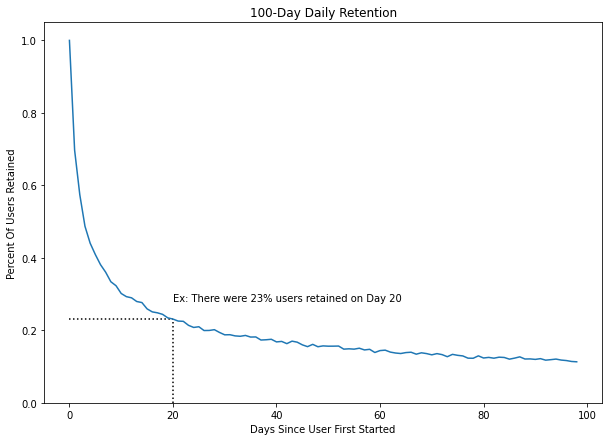

In [ ]:
whole_retention = df.groupby('days_since_start')['user_id'].nunique() / df['user_id'].nunique()

plt.figure(figsize=(10,7))
plt.plot(whole_retention)
plt.title("100-Day Daily Retention")
plt.xlabel("Days Since User First Started")
plt.ylabel("Percent Of Users Retained")
plt.ylim(0,1.05)

plt.hlines(y=whole_retention.loc[20], xmin=0, xmax=20, linestyles='dotted')
plt.vlines(x=20, ymin=0, ymax=whole_retention.loc[20], linestyles='dotted')
plt.text(s=("Ex: There were {:.0%} users retained on Day 20".format(whole_retention.loc[20])),
        x=20, y=whole_retention.loc[20] + .05);

In [ ]:
whole_retention

days_since_start
0     1.000000
1     0.697185
2     0.574293
3     0.487186
4     0.440513
        ...   
94    0.120635
95    0.117913
96    0.116585
97    0.114062
98    0.113132
Name: user_id, Length: 99, dtype: float64

In [ ]:
retention_20d = whole_retention[:21]
retention_20d

days_since_start
0     1.000000
1     0.697185
2     0.574293
3     0.487186
4     0.440513
5     0.409175
6     0.381224
7     0.360311
8     0.334019
9     0.323065
10    0.301620
11    0.292923
12    0.289669
13    0.279511
14    0.276590
15    0.259195
16    0.250896
17    0.248307
18    0.244058
19    0.234365
20    0.231045
Name: user_id, dtype: float64

<20일까지의 데이터>와 <30일까지의 데이터>를 기준으로 각각 예측 

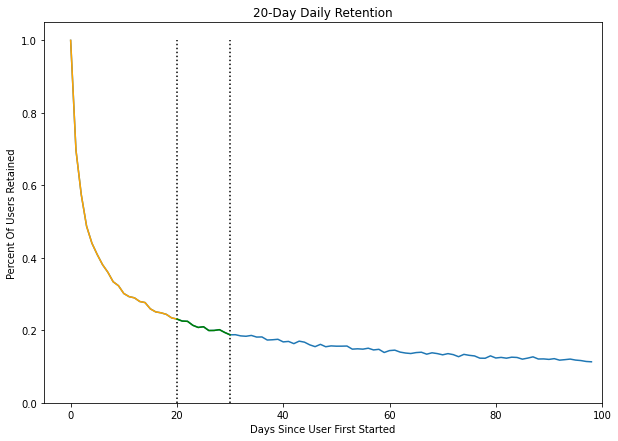

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(whole_retention)
plt.plot(retention_20d, color='orange')
plt.plot(whole_retention[20:31], color='green')
plt.title("20-Day Daily Retention")
plt.xlabel("Days Since User First Started")
plt.ylabel("Percent Of Users Retained")
plt.ylim(0,1.05)
plt.xlim(-5,100)
plt.vlines(x=20, ymin=0, ymax=1, linestyles='dotted')
plt.vlines(x=30, ymin=0, ymax=1, linestyles='dotted')

### sBG 모델

공개된 py 파일 설치하여 사용

[shifted_beta_geometric](https://github.com/jdmaturen/shifted_beta_geometric_py)

In [ ]:
pip install git+https://github.com/jdmaturen/shifted_beta_geometric_py

  Cloning https://github.com/jdmaturen/shifted_beta_geometric_py to /tmp/pip-req-build-8c3ul0vt
  Running command git clone -q https://github.com/jdmaturen/shifted_beta_geometric_py /tmp/pip-req-build-8c3ul0vt
  Created wheel for shifted-beta-geometric: filename=shifted_beta_geometric-0.0.1-py3-none-any.whl size=7493 sha256=799a2294e9893ba2d0c2cb8994a3b3c08cb026330dc88e0fd2c49428a6dba4c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-hui3umwz/wheels/e5/a6/16/612b49e9240a8f7dfc63e3489ef43816d9a8338d82d00956ce
Successfully built shifted-beta-geometric


#### 20일 데이터로 예측

In [ ]:
retention_20d.values

array([1.        , 0.69718497, 0.57429292, 0.4871863 , 0.44051255,
       0.40917541, 0.38122427, 0.36031072, 0.33401939, 0.32306467,
       0.30161997, 0.29292259, 0.28966937, 0.27951135, 0.27659009,
       0.25919533, 0.2508963 , 0.248307  , 0.24405789, 0.23436463,
       0.23104501, 0.22553446, 0.22480414, 0.21378303, 0.20794051,
       0.20986589, 0.19944231, 0.19964148, 0.20176603, 0.19406453])

In [ ]:
alpha, beta = fit(retention_20d.values)

In [ ]:
future = predicted_survival(alpha, beta, len(retention_20d) + 80)[-80:]
future = pd.Series(future)
future

0     0.215756
1     0.209044
2     0.202770
3     0.196894
4     0.191376
        ...   
75    0.068858
76    0.068288
77    0.067727
78    0.067177
79    0.066636
Length: 80, dtype: float64

In [ ]:
sBG_20d = pd.concat([retention_20d, future], ignore_index=t)
sBG_20d

0      1.000000
1      0.697185
2      0.574293
3      0.487186
4      0.440513
         ...   
96     0.068858
97     0.068288
98     0.067727
99     0.067177
100    0.066636
Length: 101, dtype: float64

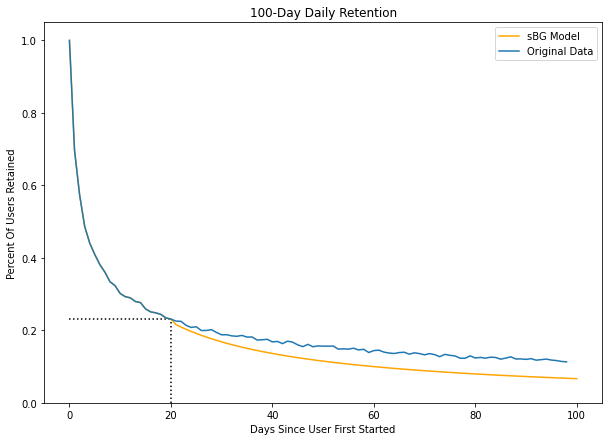

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(sBG_20d, color='orange', label='sBG Model')
plt.plot(whole_retention, label='Original Data')
plt.title("100-Day Daily Retention")
plt.xlabel("Days Since User First Started")
plt.ylabel("Percent Of Users Retained")
plt.ylim(0,1.05)
plt.legend()
plt.hlines(y=whole_retention.loc[20], xmin=0, xmax=20, linestyles='dotted')
plt.vlines(x=20, ymin=0, ymax=whole_retention.loc[20], linestyles='dotted')

#### 30일 데이터로 예측

In [ ]:
retention_30d = whole_retention[:31]
retention_30d.values

array([1.        , 0.69718497, 0.57429292, 0.4871863 , 0.44051255,
       0.40917541, 0.38122427, 0.36031072, 0.33401939, 0.32306467,
       0.30161997, 0.29292259, 0.28966937, 0.27951135, 0.27659009,
       0.25919533, 0.2508963 , 0.248307  , 0.24405789, 0.23436463,
       0.23104501, 0.22553446, 0.22480414, 0.21378303, 0.20794051,
       0.20986589, 0.19944231, 0.19964148, 0.20176603, 0.19406453,
       0.18755809])

In [ ]:
alpha, beta = fit(retention_30d.values)

In [ ]:
future = predicted_survival(alpha, beta, len(retention_30d) + 70)[-70:]
future = pd.Series(future)
future

0     0.163116
1     0.159380
2     0.155824
3     0.152437
4     0.149205
        ...   
65    0.067963
66    0.067395
67    0.066838
68    0.066291
69    0.065753
Length: 70, dtype: float64

In [ ]:
sBG_30d = pd.concat([retention_30d, future], ignore_index=t)
sBG_30d

0      1.000000
1      0.697185
2      0.574293
3      0.487186
4      0.440513
         ...   
96     0.067963
97     0.067395
98     0.066838
99     0.066291
100    0.065753
Length: 101, dtype: float64

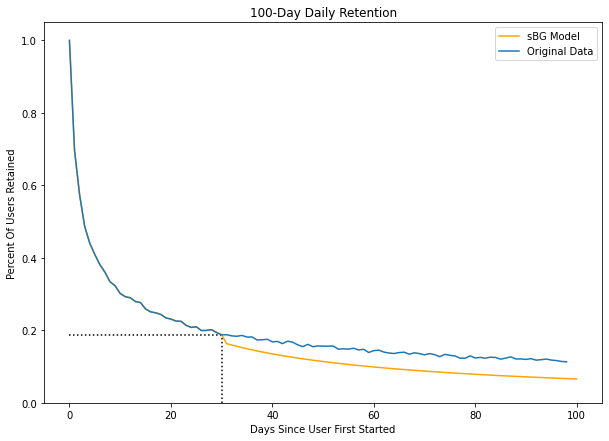

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(sBG_30d, color='orange', label='sBG Model')
plt.plot(whole_retention, label='Original Data')
plt.title("100-Day Daily Retention")
plt.xlabel("Days Since User First Started")
plt.ylabel("Percent Of Users Retained")
plt.ylim(0,1.05)
plt.legend()
plt.hlines(y=whole_retention.loc[30], xmin=0, xmax=30, linestyles='dotted')
plt.vlines(x=30, ymin=0, ymax=whole_retention.loc[30], linestyles='dotted')

#### 평가

future 예측치만 비교했을 때, 20일 데이터로 예측한 경우의 성능이 더 좋다.

In [ ]:
def MAPE(y_true, y_pred): 
	return np.mean(np.abs((y_true - y_pred) / y_true))
 
print("sBG_20d MAPE == ", MAPE(whole_retention[20:], sBG_20d[20:]))
print("sBG_30d MAPE == ", MAPE(whole_retention[30:], sBG_30d[30:]))

sBG_20d MAPE ==  0.27239000394215546
sBG_30d MAPE ==  0.3072022390662211


### 유리함수 적합

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
def func(x,a,b,c,d):
  return d / (b * (x ** a) + c)

#### 20일 데이터로 예측

`scipy`의 `curve_fit` 사용하여 파라미터 a,b,c,d 구하기

In [ ]:
popt_20d, pcov = curve_fit(func, np.arange(0,21), retention_20d.values, method='lm')
print(popt)

[0.64142521 0.45416931 0.90398208 0.90925947]


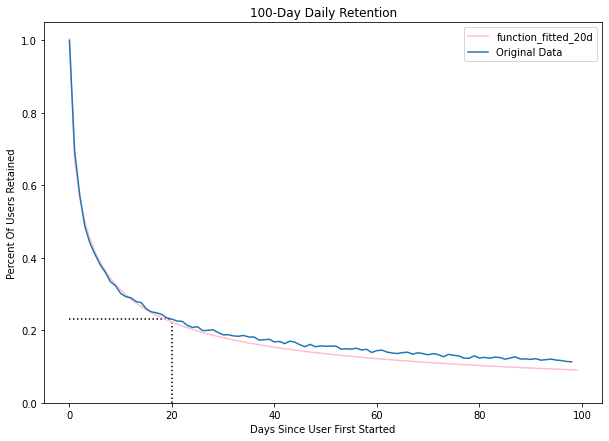

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(0,100), func(np.arange(0,100), *popt_20d), label='function_fitted_20d', color='pink')
plt.plot(whole_retention, label='Original Data')
plt.title("100-Day Daily Retention")
plt.xlabel("Days Since User First Started")
plt.ylabel("Percent Of Users Retained")
plt.ylim(0,1.05)
plt.legend()
plt.hlines(y=whole_retention.loc[20], xmin=0, xmax=20, linestyles='dotted')
plt.vlines(x=20, ymin=0, ymax=whole_retention.loc[20], linestyles='dotted')

#### 30일 데이터로 예측

In [ ]:
popt_30d, pcov = curve_fit(func, np.arange(0,31), retention_30d.values, method='lm')
print(popt)

[0.64142521 0.45416931 0.90398208 0.90925947]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  


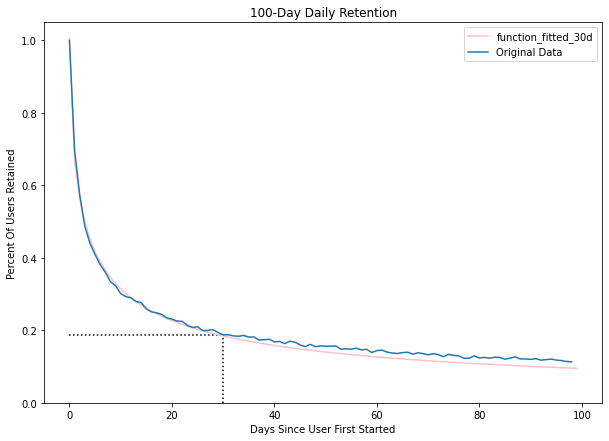

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(0,100), func(np.arange(0,100), *popt_30d), label='function_fitted_30d', color='pink')
plt.plot(whole_retention, label='Original Data')
plt.title("100-Day Daily Retention")
plt.xlabel("Days Since User First Started")
plt.ylabel("Percent Of Users Retained")
plt.ylim(0,1.05)
plt.legend()
plt.hlines(y=whole_retention.loc[30], xmin=0, xmax=30, linestyles='dotted')
plt.vlines(x=30, ymin=0, ymax=whole_retention.loc[30], linestyles='dotted')

#### 평가

In [ ]:
func(np.arange(0,99), *popt_20d)

array([1.00433377, 0.67469178, 0.56701375, 0.50032523, 0.45290951,
       0.41668909, 0.3877424 , 0.36387038, 0.34371986, 0.32640164,
       0.31130195, 0.29798057, 0.28611185, 0.2754487 , 0.26579961,
       0.2570134 , 0.24896888, 0.24156754, 0.23472836, 0.22838398,
       0.22247784, 0.21696207, 0.21179584, 0.20694406, 0.20237638,
       0.19806641, 0.19399107, 0.19013007, 0.18646549, 0.18298143,
       0.17966376, 0.17649982, 0.17347828, 0.17058892, 0.16782253,
       0.16517076, 0.16262605, 0.1601815 , 0.15783083, 0.15556827,
       0.15338856, 0.15128685, 0.14925869, 0.14729996, 0.14540687,
       0.1435759 , 0.1418038 , 0.14008754, 0.13842431, 0.13681148,
       0.13524662, 0.13372745, 0.13225182, 0.13081775, 0.12942336,
       0.12806689, 0.1267467 , 0.12546123, 0.12420901, 0.12298868,
       0.12179893, 0.12063854, 0.11950635, 0.11840125, 0.11732221,
       0.11626825, 0.11523843, 0.11423187, 0.11324772, 0.11228519,
       0.11134351, 0.11042196, 0.10951986, 0.10863654, 0.10777

In [ ]:
print("function_fitted_20d MAPE == ", MAPE(whole_retention, func(np.arange(0,99), *popt_20d)))
print("function_fitted_30d MAPE == ", MAPE(whole_retention, func(np.arange(0,99), *popt_30d)))

function_fitted_20d MAPE ==  0.11352963108809326
function_fitted_30d MAPE ==  0.0875042266700284


### 성능 비교

In [ ]:
MAPE_df = pd.DataFrame({'model':['sBG (20일)', 'sBG (30일)', '유리함수 (20일)', '유리함수 (30일)'],
                     'MAPE':[MAPE(whole_retention[20:], sBG_20d[20:]), 
                             MAPE(whole_retention[30:], sBG_30d[30:]), 
                             MAPE(whole_retention, func(np.arange(0,99), *popt_20d)),
                             MAPE(whole_retention, func(np.arange(0,99), *popt_30d))]})
  
MAPE_df

,model,MAPE
0,sBG (20일),0.272390
1,sBG (30일),0.307202
2,유리함수 (20일),0.113530
3,유리함수 (30일),0.087504


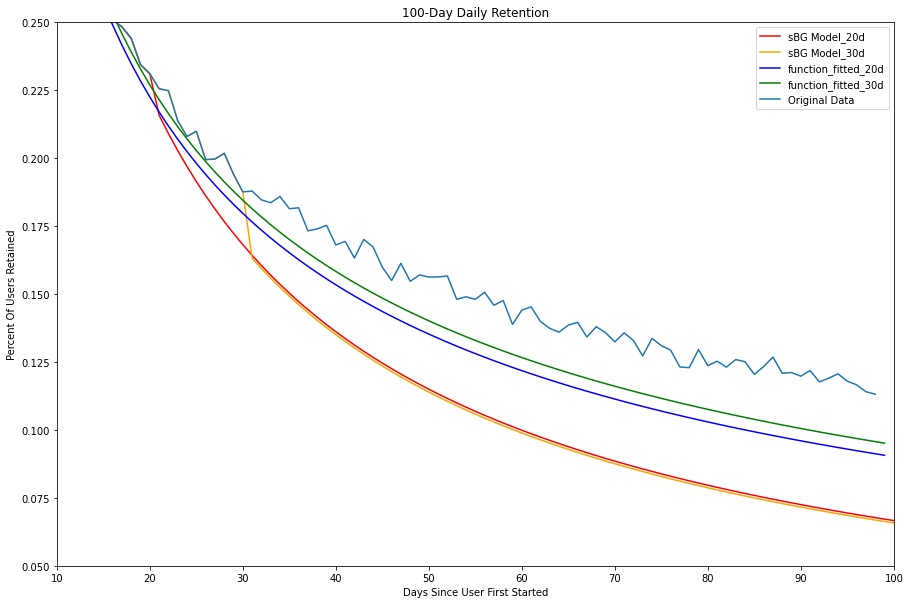

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(sBG_20d, color='red', label='sBG Model_20d')
plt.plot(sBG_30d, color='orange', label='sBG Model_30d')
plt.plot(np.arange(0,100), func(np.arange(0,100), *popt_20d), label='function_fitted_20d', color='blue')
plt.plot(np.arange(0,100), func(np.arange(0,100), *popt_30d), label='function_fitted_30d', color='green')

plt.plot(whole_retention, label='Original Data')

plt.title("100-Day Daily Retention")
plt.xlabel("Days Since User First Started")
plt.ylabel("Percent Of Users Retained")
plt.ylim(0.05,0.25)
plt.xlim(10,100)
plt.legend()